In [904]:
import numpy as np
import utils
import plotting_tools as pt

from importlib import reload
import utils
utils = reload(utils)
pt = reload(pt)

from scipy import signal

In [1136]:
Nx = 128
Ny = 1
Nz = 128
et = 86400.0*10.0
# et = 1E6

# Nx = 150
# Ny = 1
# Nz = 150
# et = 1E6

N = 1
base_fn = 'output_swe'
pydir = '../%s/' %base_fn

tc = utils.test_case(base_fn, pydir, Nx, Ny, et, Nz=Nz)
tags = tc.get_tag_dict()

after_full_step


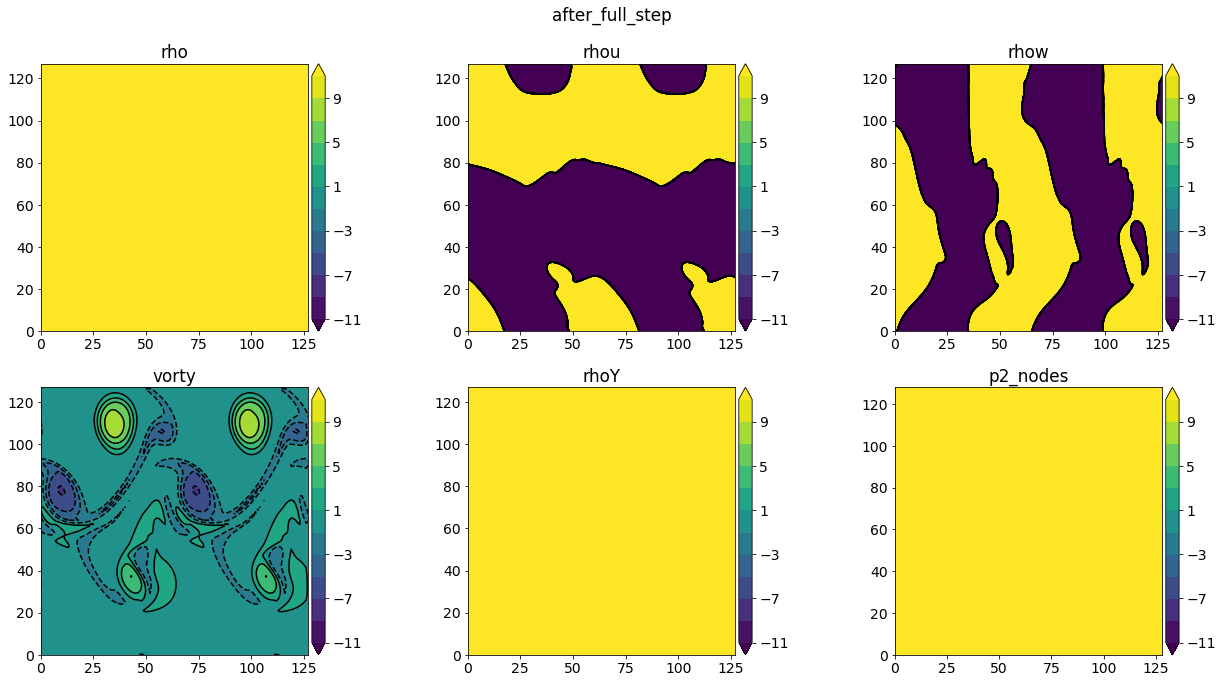

In [1163]:
# comp_sfx = 'comp_last_working_ic0'
# H = 'optimal'
# comp_sfx = 'comp_H=%s' %str(H)
comp_sfx = 'icshear_3D'
# comp_sfx = 'dvortex_3D'
# comp_sfx = 'comp'
fn = tc.get_filename(N,comp_sfx)
path = tc.get_path(fn)

attributes = ['rho','rhou','rhow','vorty','rhoY','p2_nodes']
# attributes = ['vorty']
# attributes = ['rho','rhoY','Y']
# attributes = ['rho']
times = [0,100] #, 150, 180, 260, 280]
times = np.arange(0,719)
# times = [0,399]
# times = [72*10-1]
times = [9]

tag = tags[9]
print(tag)
# tag = 'ic'
H = 1076.0

slc = 0
arr_lst = []
time_series = np.zeros((np.array(times).shape[0],len(attributes),2), dtype='object')

class oo(object):
    def __init__(self):
        None
        
oo = oo()

for tt,time in enumerate(times):
#     for i in range(10):
#         tag = tags[i]
#         arr_lst = []
    for atr_idx, attribute in enumerate(attributes):
        if len(times) == 2:
            
            arr1 = tc.get_arr(path, times[1], N, attribute, label_type='WINDOW_STEP', tag=tag, inner=False, avg=False)[0][:,slc,:]
            arr0 = tc.get_arr(path, times[0], N, attribute, label_type='WINDOW_STEP', tag=tag, inner=False, avg=False)[0][:,slc,:]

            arr = arr1 - arr0
        else:
            arr = tc.get_arr(path, time, N, attribute, label_type='STEP', tag=tag, inner=True, avg=False)[0][:,slc,:]
            arr = arr.T

        if attribute == 'rho':
            rho = np.copy(arr)
            setattr(oo,attribute,arr)
#             arr -= H
        if attribute == 'vorty':
            kernel = np.array([[1.0,1.0],[1.0,1.0]])
            kernel /= kernel.sum()
            arr = signal.convolve(arr, kernel, mode='valid')
            arr /= rho
            arr *= 86400.0*1000
#             arr = arr[::-1,:]

        if attribute == 'rhoY':
            rhoY = np.copy(arr)
            
        if attribute == 'rhou' or attribute == 'rhow':
#             arr /= rho
            
            setattr(oo,attribute,arr)
#             None
            
        arr_lst.append([arr,attribute])
        arr = [arr,attribute]
        time_series[tt,atr_idx] = arr

    pl = pt.plotter(arr_lst,ncols=3,figsize=(18,10))
#     lvls = np.arange(-0.45,1.7,0.1)
    lvls = np.arange(-11.0,11.1,2)
#     lvls = np.arange(H-60,H+42,2)

    _ = pl.plot(aspect='equal',method='contour',suptitle=tag,lvls=lvls)
#     _ = pl.plot(aspect='equal',method='contour',suptitle=tag)
#     ts.append(arr_lst)

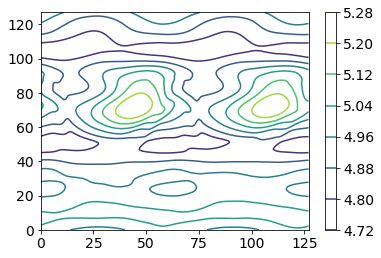

In [1083]:
import matplotlib.pyplot as plt

u = oo.rhou / oo.rho
w = oo.rhow / oo.rho

dudz = np.gradient(u,axis=1)
dwdx = np.gradient(w,axis=0)

pv = (dudz - dwdx) / oo.rho

def Dx(u,N,L,I):
    us = np.roll(u,-I,axis=1)
    return I * N/L * (us-u)

def Dy(u,N,L,I):
    us = np.roll(u,-I,axis=0)
    return I * N/L * (us-u)

Nx = 128
Lx = 5000.0 * 1E3
Ly = 4330.0 * 1E3
pv = (Dx(w,N,Lx,+1) - Dy(u,N,Ly,+1) + (6.147 * 1E-5)) / oo.rho
pv *= 86400*1000.0

plt.figure()
plt.contour(pv)
plt.colorbar()
plt.show()

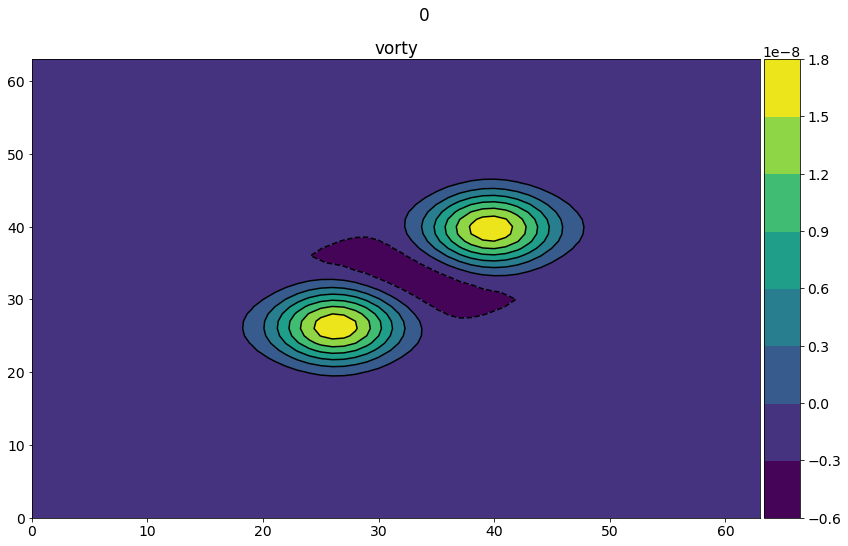

In [811]:
a2d = pt.animator_2D(time_series,ncols=3,figsize=(12,8))
anim = a2d.animate(interval=200, aspect='equal', method='contour')

In [812]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [295]:
Lx = 5000.0
Ly = 4330.0
sigx = 3.0 / 40 * Lx
sigy = 3.0 / 40 * Ly

sig = 0.5 * (sigx + sigy)
d = 4.0 * sig



In [63]:
# y = [-0.6915855407714844, -0.06304168701171875, -0.00130462646484375, 0.041015625, 0.15082550048828125, 3.5741424560546875]
# x = [50, 90, 93, 95, 100, 200]

y = [0.70944595, 0.06523895, 0.0018615723, -0.04156494, -0.1542511, -3.6651459]
x = [50, 90, 93, 95, 100, 200]

x = x[:-1]
y = y[:-1]
x = x[1:]
y = y[1:]

dx = x[-1] - x[0]
dy = y[-1] - y[0]

xx = np.arange(x[0],x[-1]+1)
b = y[2] - dy/dx * x[2]
# yy = dy/dx * xx + b

xo = -b / (dy/dx)
# print(xo)

z = np.polyfit(x, y, 1)
zz = np.poly1d(z)
root = np.roots(zz)
yy = z[0] * xx + z[1]

a = xo
# print(a)

plt.figure(figsize=(9,6))
plt.plot(x,y, '-o', label='measurements')
plt.xlabel("mean water height H")
plt.ylabel("deviation of the 'blob'")
plt.axvline(root, c='g', lw=1.0, label=r'optimal H $\approx$ %.3f' %root)
plt.plot(xx,yy, label='linear best fit')
plt.axhline(0.0, c='k', ls='--', lw=0.5)
plt.legend()
plt.grid()
plt.show()

print(root)

NameError: name 'plt' is not defined

In [140]:
%%capture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
import matplotlib
%matplotlib inline

from IPython.display import HTML

# ref: https://pythonmatplotlibtips.blogspot.com/2018/11/animation-3d-surface-plot-funcanimation-matplotlib.html
N = 150 # Meshsize
# et = 1E6

Lx, Lz = 1E6, 1E6
x = np.linspace(0,Lx,Nx) / 1000
z = np.linspace(0,Lz,Nz) / 1000

H = 100.0
N = 1

X, Z = np.meshgrid(x, z)

frns = np.arange(0,301) # animation frames
time_series = np.zeros((frns.shape[0],Nx,Nz))

comp_sfx = 'comp'
fn = tc.get_filename(N,comp_sfx)
path = tc.get_path(fn)

attribute = 'rho'

for ii,fr in enumerate(frns):
    time_series[ii] = tc.get_arr(path, fr, N, attribute, label_type='STEP', inner=True)[:,0,:] - H
    
def update_plot(frame_number, time_series, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(X, Z, time_series[frame_number,:,:], cmap="magma")

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

plot = [ax.plot_surface(X, Z, time_series[0,:,:], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(-.5,.5)
ax.set_xlabel(r'$L_x$ [km]')
ax.set_ylabel(r'$L_z$ [km]')
ax.set_zlabel(r'$\delta h$ [m]')
ax.view_init(60, 45)
anim = animation.FuncAnimation(fig, update_plot, frns, fargs=(time_series, plot), interval=100)

In [141]:
HTML(anim.to_html5_video())

0.010000001


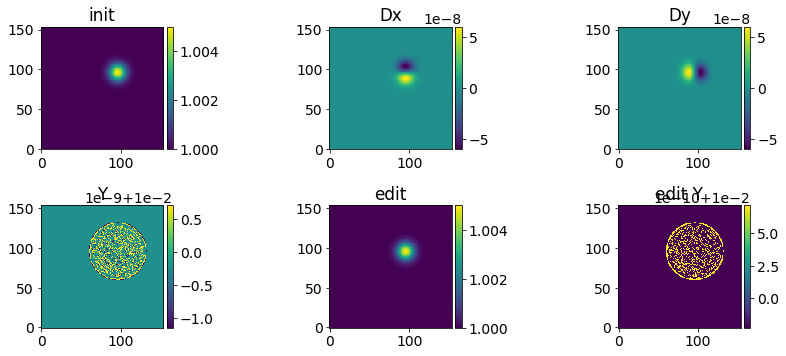

In [80]:
comp_sfx = 'comp'
fn = tc.get_filename(N,comp_sfx)
path = tc.get_path(fn)

init = tc.get_arr(path, 0, N, 'rhoY', label_type='STEP', tag='ic', inner=False, avg=False)[0]
init_rho = tc.get_arr(path, 0, N, 'rho', label_type='STEP', tag='ic', inner=False, avg=False)[0]

dx, dy = np.diff(x)[0], np.diff(y)[0]

Dx = np.gradient(init,dx,axis=0)
Dy = np.gradient(init,dy,axis=1)

# edit = init - (Dx + Dy)

# eDx = np.gradient(edit,dx,axis=0)
# eDy = np.gradient(edit,dy,axis=1)

edit = init_rho / 100.0
# edit -= edit.mean()
# edit += 1.0

arr_lst = [[init, "init"], [Dx,'Dx'], [Dy,'Dy']]
Y = init / init_rho
arr_lst += [[Y, 'Y'], [edit, 'edit'], [edit / init_rho, 'edit Y']]
# arr_lst += [[edit, "edit"], [eDx,'eDx'], [eDy,'eDy']]
pl = pt.plotter(arr_lst,ncols=3)
pl.plot(aspect='equal')


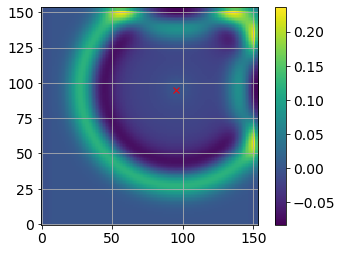

0.0010681152
0.9978649104014039


In [502]:
rhoY = tc.get_arr(path, 100, N, 'rho', label_type='STEP', inner=False, avg=False)[0]

idx = [103,93]
idx = [95,95]

rhoY = rhoY - H

plt.figure()
plt.imshow(rhoY[:,:], origin='lower',aspect='equal')
plt.plot(idx[0],idx[1],'rx')
plt.colorbar()
plt.grid()
plt.show()

print(rhoY[idx[0],idx[1]])
print((1.0 - rhoY[idx[0],idx[1]])**2)

In [504]:
0.16827393 /0.0010681152

157.54286616275098

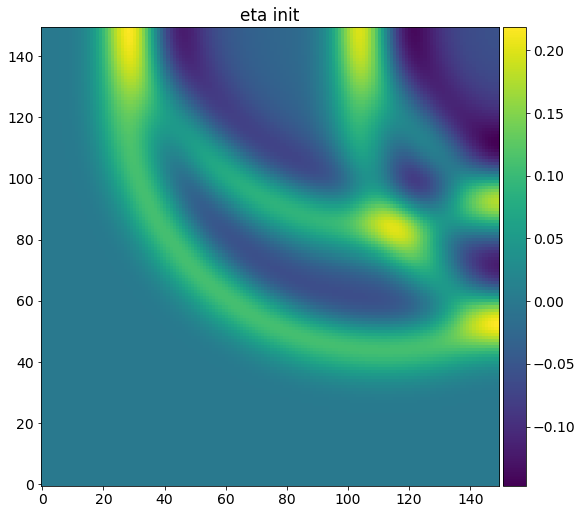

In [145]:
eta = np.load('../output_swe/eta_list.npy')

eta_init = eta[40]
eta_lst = [[eta_init, "eta init"]]
pl = pt.plotter(eta_lst,ncols=1)
pl.plot(aspect='equal')